In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time, datetime

import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Load Data

In [5]:
data_dir = '/mnt/disk2/data/private_data/SSM/2_Mockup/1_AE_Accel_Data/3_Loc1_2'

def GBdataLoad2(data_dir, phase = 'train', data = 'AE'):
    for i in os.listdir(data_dir):
        if 'good' in i and phase in i and data in i:
            G_train_X = np.load(os.path.join(data_dir, i))
        elif 'bad' in i and phase in i and data in i:
            B_train_X = np.load(os.path.join(data_dir, i))
            
    def add_ch(img):
        """
        (sample #, height, width,) -> (sample #, height, width, channel)
        """
        return np.expand_dims(img, axis = -1)

    return add_ch(G_train_X), add_ch(B_train_X)

AE_G_train_X, AE_B_train_X = GBdataLoad2(data_dir, phase = 'train', data = 'AE')
print('AE data', AE_G_train_X.shape, AE_B_train_X.shape, '\n')

Accel_G_train_X, Accel_B_train_X = GBdataLoad2(data_dir, phase = 'train', data = 'accel')
print('Accel data', Accel_G_train_X.shape, Accel_B_train_X.shape, '\n')

G_train_X = np.concatenate((AE_G_train_X, Accel_G_train_X), axis = -1)
B_train_X = np.concatenate((AE_B_train_X, Accel_B_train_X), axis = -1)

print('GOOD:', G_train_X.shape, 'BAD', B_train_X.shape)

AE data (1224, 40, 40, 1) (1028, 40, 40, 1) 

Accel data (1224, 40, 40, 1) (1028, 40, 40, 1) 

GOOD: (1224, 40, 40, 2) BAD (1028, 40, 40, 2)


In [6]:
def input_for_Pytorch(img):
    """
    (sample #, height, width, channel) -> (sample #, channel, height, width)
    """
    img = np.transpose(img, (0, 3, 1, 2))
    return img

G_train_X = input_for_Pytorch(G_train_X)
B_train_X = input_for_Pytorch(B_train_X)

G_train_X.shape, B_train_X.shape

((1224, 2, 40, 40), (1028, 2, 40, 40))

In [7]:
def CreateLabel(data, cls):
    label = cls*np.ones([data.shape[0]])
    return label

G_train_Y, B_train_Y = CreateLabel(G_train_X, 0), CreateLabel(B_train_X, 1)

G_train_X.shape, G_train_Y.shape, B_train_X.shape, B_train_Y.shape

((1224, 2, 40, 40), (1224,), (1028, 2, 40, 40), (1028,))

In [8]:
def train_valid_split(data, label, rate_t_v = 0.9):
    data_num = len(data)
    train_idx = np.random.choice(data_num, int(rate_t_v*data_num), replace = False)
    valid_idx = np.setdiff1d(np.arange(data_num), train_idx)
    return data[train_idx], label[train_idx], data[valid_idx], label[valid_idx]

G_train_X, G_train_Y, G_valid_X, G_valid_Y = train_valid_split(G_train_X, G_train_Y)
B_train_X, B_train_Y, B_valid_X, B_valid_Y = train_valid_split(B_train_X, B_train_Y)

print("Training:", G_train_X.shape, G_train_Y.shape, B_train_X.shape, B_train_Y.shape)
print("Validation:", G_valid_X.shape, G_valid_Y.shape, B_valid_X.shape, B_valid_Y.shape)

Training: (1101, 2, 40, 40) (1101,) (925, 2, 40, 40) (925,)
Validation: (123, 2, 40, 40) (123,) (103, 2, 40, 40) (103,)


# Model

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # RGB세개 1채널, 20개 특징 추출, filter 크기, stride 1
        self.conv1_1 = nn.Conv2d(2, 64, 3, 1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.conv4_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv4_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.dense1 = nn.Linear(2*2*64, 128)
        # 0.5 가 권장 할 만하대
        self.dropout1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(128, 2)  
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_bn(self.conv1_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_bn(self.conv2_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_bn(self.conv3_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_bn(self.conv4_2(x)))
        x = F.max_pool2d(x, 2, 2)
        # flatten
        x = x.view(-1, 2*2*64)
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

In [10]:
model = ConvNet()
# model = model.cuda()
model = model.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

summary(model, (2, 40, 40), device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]           1,216
            Conv2d-2           [-1, 64, 40, 40]          36,928
       BatchNorm2d-3           [-1, 64, 40, 40]             128
            Conv2d-4           [-1, 64, 20, 20]          36,928
            Conv2d-5           [-1, 64, 20, 20]          36,928
       BatchNorm2d-6           [-1, 64, 20, 20]             128
            Conv2d-7           [-1, 64, 10, 10]          36,928
            Conv2d-8           [-1, 64, 10, 10]          36,928
       BatchNorm2d-9           [-1, 64, 10, 10]             128
           Conv2d-10             [-1, 64, 5, 5]          36,928
           Conv2d-11             [-1, 64, 5, 5]          36,928
      BatchNorm2d-12             [-1, 64, 5, 5]             128
           Linear-13                  [-1, 128]          32,896
          Dropout-14                  [

(tensor(293378), tensor(293378))

# Training

In [11]:
def RandomMinibatch(data, label, n_batch = 100):
    batch_idx = np.random.choice(len(data), n_batch, replace = False)
    return data[batch_idx], label[batch_idx]

G_train_x, G_train_y = RandomMinibatch(G_train_X, G_train_Y, 100)
B_train_x, B_train_y = RandomMinibatch(B_train_X, B_train_Y, 100)

G_valid_x, G_valid_y = RandomMinibatch(G_valid_X, G_valid_Y, 100)
B_valid_x, B_valid_y = RandomMinibatch(B_valid_X, B_valid_Y, 100)

print("Training:", G_train_x.shape, G_train_y.shape, B_train_x.shape, B_train_y.shape)
print("Validation:", G_valid_x.shape, G_valid_y.shape, B_valid_x.shape, B_valid_y.shape)

Training: (100, 2, 40, 40) (100,) (100, 2, 40, 40) (100,)
Validation: (100, 2, 40, 40) (100,) (100, 2, 40, 40) (100,)


In [12]:
def shuffle(x, y):
    """
    random shuffle of two paired data -> x, y = shuffle(x, y)
    but, available of one data -> x = shuffle(x, None)
    """
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    if type(x) == type(y):
        return x[idx], y[idx] 
    else:
        return x[idx]
    
G_train_x, G_train_y = RandomMinibatch(G_train_X, G_train_Y, 100)
B_train_x, B_train_y = RandomMinibatch(B_train_X, B_train_Y, 100)
    
train_x, train_y = np.vstack([G_train_x, B_train_x]), np.hstack([G_train_y, B_train_y])
train_x, train_y = shuffle(train_x, train_y)

print("Training", train_x.shape, train_y.shape)

Training (200, 2, 40, 40) (200,)


In [13]:
loss_history, accr_history = [], []
val_loss_history, val_accr_history = [], []

iter_i = 0

while True:
    iter_i += 1
    
    G_train_x, G_train_y = RandomMinibatch(G_train_X, G_train_Y, 100)
    B_train_x, B_train_y = RandomMinibatch(B_train_X, B_train_Y, 100)
    
    train_x, train_y = np.vstack([G_train_x, B_train_x]), np.hstack([G_train_y, B_train_y])

    train_x, train_y = shuffle(train_x, train_y)
    
#     train_x, train_y = train_x.to(device), train_y.to(device)
    train_x, train_y = torch.tensor(train_x, device=device).float(), torch.tensor(train_y, device=device).long()
    
    output = model(train_x)
    loss = criterion(output, train_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iter_i % 10 == 0:
        
        _, pred = torch.max(output, 1)
        
        loss_history.append(loss.tolist())
        accr_history.append((torch.sum(pred == train_y.data).tolist() / len(train_y)))
        
        with torch.no_grad():
    
            G_valid_x, G_valid_y = RandomMinibatch(G_valid_X, G_valid_Y, 100)
            B_valid_x, B_valid_y = RandomMinibatch(B_valid_X, B_valid_Y, 100)

            valid_x, valid_y = np.vstack([G_valid_x, B_valid_x]), np.hstack([G_valid_y, B_valid_y])
#             valid_x, valid_y = valid_x.to(device), valid_y.to(device)
            valid_x, valid_y = torch.tensor(valid_x, device=device).float(), torch.tensor(valid_y, device=device).long()

            valid_output = model(valid_x)
            valid_loss = criterion(valid_output, valid_y)
            
            _, valid_pred = torch.max(valid_output, 1)
        
            val_loss_history.append(valid_loss.tolist())
            val_accr_history.append((torch.sum(valid_pred == valid_y.data).tolist() / len(valid_y)))
        
        
        print("{:05d} | train_loss: {:.5f}, train_accr: {:.3f} | val_loss: {:.5f}, val_accr: {:.3f}".format(iter_i, 
                                                                                                            loss_history[-1], 
                                                                                                            accr_history[-1], 
                                                                                                            val_loss_history[-1], 
                                                                                                            val_accr_history[-1]))
        
        if iter_i >= 100:  
#             if np.mean(val_loss_history[-5 :]) >= np.mean(val_loss_history[-10:]):
#                 print('')
#                 print('Early stopping!!')
#                 print('..val_loss (avg. within 5): {:.5f} >= val_loss (avg. within 10) {:.5f}'.format(np.mean(val_loss_history[-5 :]),
#                                                                                                   np.mean(val_loss_history[-10:])))
                
            if val_loss_history[-1] == np.min(val_loss_history):

                now = datetime.datetime.now()
                nowDatetime = now.strftime('%y%m%d%H%M')
                model_name = 'A2_1_GB_{}_{:05d}_loss_{:.6f}_val_loss_{:.6f}.pt'.format(nowDatetime, iter_i, 
                                                                                     np.mean(loss_history[-3:]),
                                                                                     np.mean(val_loss_history[-3:]))
                torch.save(model.state_dict(), './model/3_Loc1/' + model_name)
#                 break                   
        if iter_i == 5000:
            break

00010 | train_loss: 0.67810, train_accr: 0.595 | val_loss: 0.65941, val_accr: 0.625
00020 | train_loss: 0.60908, train_accr: 0.675 | val_loss: 0.61272, val_accr: 0.660
00030 | train_loss: 0.61326, train_accr: 0.670 | val_loss: 0.59408, val_accr: 0.715
00040 | train_loss: 0.55214, train_accr: 0.740 | val_loss: 0.55357, val_accr: 0.725
00050 | train_loss: 0.50262, train_accr: 0.805 | val_loss: 0.49118, val_accr: 0.815
00060 | train_loss: 0.47989, train_accr: 0.785 | val_loss: 0.46194, val_accr: 0.820
00070 | train_loss: 0.43034, train_accr: 0.835 | val_loss: 0.42158, val_accr: 0.830
00080 | train_loss: 0.40904, train_accr: 0.865 | val_loss: 0.41898, val_accr: 0.825
00090 | train_loss: 0.40497, train_accr: 0.825 | val_loss: 0.37455, val_accr: 0.870
00100 | train_loss: 0.40327, train_accr: 0.845 | val_loss: 0.36848, val_accr: 0.855
00110 | train_loss: 0.31845, train_accr: 0.905 | val_loss: 0.36652, val_accr: 0.855
00120 | train_loss: 0.31521, train_accr: 0.905 | val_loss: 0.38797, val_accr

00990 | train_loss: 0.01334, train_accr: 1.000 | val_loss: 0.14022, val_accr: 0.950
01000 | train_loss: 0.01421, train_accr: 1.000 | val_loss: 0.13380, val_accr: 0.940
01010 | train_loss: 0.01992, train_accr: 1.000 | val_loss: 0.14857, val_accr: 0.940
01020 | train_loss: 0.01969, train_accr: 0.995 | val_loss: 0.15481, val_accr: 0.940
01030 | train_loss: 0.01440, train_accr: 1.000 | val_loss: 0.19625, val_accr: 0.935
01040 | train_loss: 0.01060, train_accr: 1.000 | val_loss: 0.16108, val_accr: 0.940
01050 | train_loss: 0.00917, train_accr: 1.000 | val_loss: 0.16594, val_accr: 0.940
01060 | train_loss: 0.01210, train_accr: 1.000 | val_loss: 0.19107, val_accr: 0.940
01070 | train_loss: 0.00871, train_accr: 1.000 | val_loss: 0.16080, val_accr: 0.945
01080 | train_loss: 0.01239, train_accr: 1.000 | val_loss: 0.17741, val_accr: 0.945
01090 | train_loss: 0.01305, train_accr: 1.000 | val_loss: 0.18272, val_accr: 0.940
01100 | train_loss: 0.01205, train_accr: 1.000 | val_loss: 0.16715, val_accr

01970 | train_loss: 0.00225, train_accr: 1.000 | val_loss: 0.14261, val_accr: 0.960
01980 | train_loss: 0.00257, train_accr: 1.000 | val_loss: 0.16132, val_accr: 0.955
01990 | train_loss: 0.00185, train_accr: 1.000 | val_loss: 0.20544, val_accr: 0.935
02000 | train_loss: 0.00263, train_accr: 1.000 | val_loss: 0.14009, val_accr: 0.965
02010 | train_loss: 0.00192, train_accr: 1.000 | val_loss: 0.15947, val_accr: 0.945
02020 | train_loss: 0.00266, train_accr: 1.000 | val_loss: 0.19903, val_accr: 0.940
02030 | train_loss: 0.00160, train_accr: 1.000 | val_loss: 0.21567, val_accr: 0.940
02040 | train_loss: 0.00113, train_accr: 1.000 | val_loss: 0.18404, val_accr: 0.950
02050 | train_loss: 0.00132, train_accr: 1.000 | val_loss: 0.18595, val_accr: 0.950
02060 | train_loss: 0.00250, train_accr: 1.000 | val_loss: 0.21546, val_accr: 0.935
02070 | train_loss: 0.00206, train_accr: 1.000 | val_loss: 0.19258, val_accr: 0.955
02080 | train_loss: 0.00240, train_accr: 1.000 | val_loss: 0.24971, val_accr

02950 | train_loss: 0.00071, train_accr: 1.000 | val_loss: 0.26824, val_accr: 0.945
02960 | train_loss: 0.00224, train_accr: 1.000 | val_loss: 0.27404, val_accr: 0.935
02970 | train_loss: 0.00067, train_accr: 1.000 | val_loss: 0.25049, val_accr: 0.950
02980 | train_loss: 0.00051, train_accr: 1.000 | val_loss: 0.25700, val_accr: 0.940
02990 | train_loss: 0.00052, train_accr: 1.000 | val_loss: 0.26524, val_accr: 0.930
03000 | train_loss: 0.00109, train_accr: 1.000 | val_loss: 0.19937, val_accr: 0.945
03010 | train_loss: 0.00110, train_accr: 1.000 | val_loss: 0.19974, val_accr: 0.950
03020 | train_loss: 0.00080, train_accr: 1.000 | val_loss: 0.24035, val_accr: 0.945
03030 | train_loss: 0.00053, train_accr: 1.000 | val_loss: 0.25353, val_accr: 0.940
03040 | train_loss: 0.00089, train_accr: 1.000 | val_loss: 0.25678, val_accr: 0.925
03050 | train_loss: 0.00117, train_accr: 1.000 | val_loss: 0.23373, val_accr: 0.940
03060 | train_loss: 0.00052, train_accr: 1.000 | val_loss: 0.18812, val_accr

03930 | train_loss: 0.00042, train_accr: 1.000 | val_loss: 0.26393, val_accr: 0.945
03940 | train_loss: 0.00028, train_accr: 1.000 | val_loss: 0.23714, val_accr: 0.950
03950 | train_loss: 0.00031, train_accr: 1.000 | val_loss: 0.20176, val_accr: 0.950
03960 | train_loss: 0.00033, train_accr: 1.000 | val_loss: 0.25779, val_accr: 0.940
03970 | train_loss: 0.00028, train_accr: 1.000 | val_loss: 0.15244, val_accr: 0.955
03980 | train_loss: 0.00035, train_accr: 1.000 | val_loss: 0.27772, val_accr: 0.945
03990 | train_loss: 0.00026, train_accr: 1.000 | val_loss: 0.26838, val_accr: 0.935
04000 | train_loss: 0.00025, train_accr: 1.000 | val_loss: 0.27189, val_accr: 0.940
04010 | train_loss: 0.00023, train_accr: 1.000 | val_loss: 0.27586, val_accr: 0.940
04020 | train_loss: 0.00033, train_accr: 1.000 | val_loss: 0.24723, val_accr: 0.950
04030 | train_loss: 0.00014, train_accr: 1.000 | val_loss: 0.18875, val_accr: 0.945
04040 | train_loss: 0.00022, train_accr: 1.000 | val_loss: 0.23327, val_accr

04910 | train_loss: 0.00011, train_accr: 1.000 | val_loss: 0.32545, val_accr: 0.940
04920 | train_loss: 0.00019, train_accr: 1.000 | val_loss: 0.30933, val_accr: 0.935
04930 | train_loss: 0.00015, train_accr: 1.000 | val_loss: 0.23438, val_accr: 0.950
04940 | train_loss: 0.00016, train_accr: 1.000 | val_loss: 0.27126, val_accr: 0.945
04950 | train_loss: 0.00014, train_accr: 1.000 | val_loss: 0.20755, val_accr: 0.950
04960 | train_loss: 0.00021, train_accr: 1.000 | val_loss: 0.27398, val_accr: 0.945
04970 | train_loss: 0.00014, train_accr: 1.000 | val_loss: 0.19675, val_accr: 0.955
04980 | train_loss: 0.00015, train_accr: 1.000 | val_loss: 0.31551, val_accr: 0.935
04990 | train_loss: 0.00011, train_accr: 1.000 | val_loss: 0.24953, val_accr: 0.950
05000 | train_loss: 0.00009, train_accr: 1.000 | val_loss: 0.28992, val_accr: 0.945


/home/yunseob/Pytorch/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


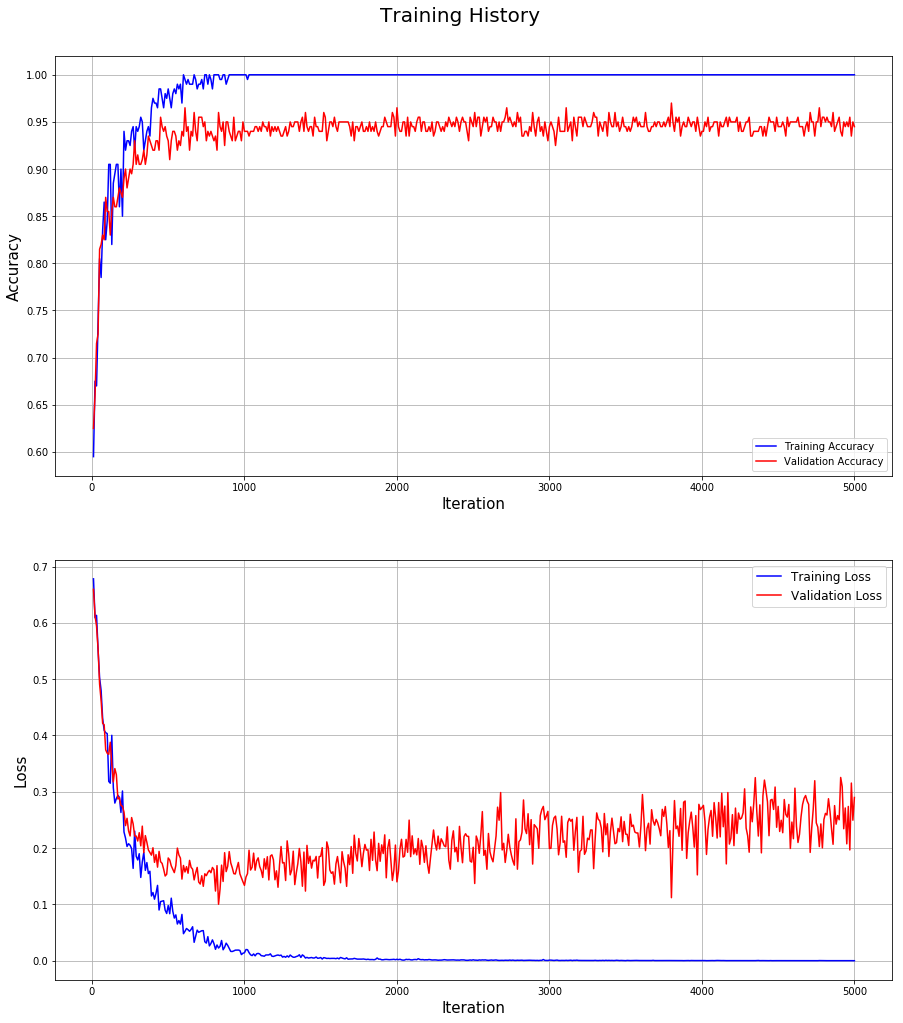

In [14]:
fig = plt.figure(figsize = (15,17))
plt.suptitle('Training History', y = 0.92, fontsize = 20)

# x_axis = range(1, 10*len(accr_history)+1, 10)
x_axis = np.arange(10, 10*len(accr_history)+1, 10)

plt.subplot(2, 1, 1)
plt.plot(x_axis, accr_history, 'b-', label = 'Training Accuracy')
plt.plot(x_axis, val_accr_history, 'r-', label = 'Validation Accuracy')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend(fontsize = 10)
plt.grid('on')
plt.subplot(2, 1, 2)
plt.plot(x_axis, loss_history, 'b-', label = 'Training Loss')
plt.plot(x_axis, val_loss_history, 'r-', label = 'Validation Loss')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
# plt.yticks(np.arange(0, 0.25, step=0.025))
plt.legend(fontsize = 12)
plt.grid('on')
plt.show()

# if save == True:
#     fig.savefig(hist_path + filename)
#     plt.close(fig)

In [15]:
np.save('./results/0_train_hist/npy/A2_1_GB_accr_history', accr_history)
np.save('./results/0_train_hist/npy/A2_1_GB_val_accr_history', val_accr_history)
np.save('./results/0_train_hist/npy/A2_1_GB_loss_history', loss_history)
np.save('./results/0_train_hist/npy/A2_1_GB_val_loss_history', val_loss_history)